# Comparison of XGBoost and neural network outputs for 10k patient cohort

## Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

## Load data

Data as previously calculated

In [2]:
data = pd.read_csv('./predictions/xgb_nn_comparison.csv')
data.head().T

,0,1,2,3,4
Order,1,2,3,4,5
Stroke team,VUHVS8909F,HZNVT9936G,FAJKD7118X,TPXYE0168D,DNOYM6465G
Thrombolysis,0,0,1,1,0
xgb_shap_patient_subset_total,-9.007,-5.264,-1.841,1.93,-1.801
xgb_shap_hospital_subset_total,0.196,0.12,0.577,1.786,0.888
xgb_shap_hospital_main_shap,-0.15,0.266,-0.386,0.871,0.054
xgb_total_shap_without_base,-7.112,-5.374,1.245,5.908,1.02
xgb_total_shap_with_base,-10.057,-8.319,-1.701,2.963,-1.925
xgb_probs,0.0,0.0,0.154,0.951,0.127
xgb_thrombolysis,0,0,0,1,0


## Observed and predicted thrombolyis rates

In [3]:
observed_rx = data['Thrombolysis'].mean()
xgb_rx = data['xgb_thrombolysis'].mean()
nn_rx = data['nn_thrombolysis'].mean()

print (f'Observed thrombolysis: {observed_rx:0.3f}')
print (f'XGB predicted thrombolysis: {xgb_rx:0.3f}')
print (f'NN predicted thrombolysis: {nn_rx:0.3f}')

Observed thrombolysis: 0.296
XGB predicted thrombolysis: 0.296
NN predicted thrombolysis: 0.281


## Accuracy and agreement between models

In [4]:
xgb_accuracy = np.mean(data['xgb_thrombolysis'] == data['Thrombolysis'])
nn_accuracy = np.mean(data['nn_thrombolysis'] == data['Thrombolysis'])
model_agreement = np.mean(data['nn_thrombolysis'] == data['xgb_thrombolysis'])

print (f'XGB accuracy: {xgb_accuracy:0.3f}')
print (f'NN accuracy: {nn_accuracy:0.3f}')
print (f'Model_agreement: {model_agreement:0.3f}')                    

XGB accuracy: 0.848
NN accuracy: 0.840
Model_agreement: 0.926


## Compare probalities of thrombolysis

In [ ]:
# Bin by XGBoost probability of thrombolysis
bins = np.arange(0, 1.01, 0.05)
data['binned_by_xgb_probability_thrombolysis'] = np.digitize(data['xgb_probs'], bins=bins)

## Compare number of hospitals predicted to give thrombolysis to each patient

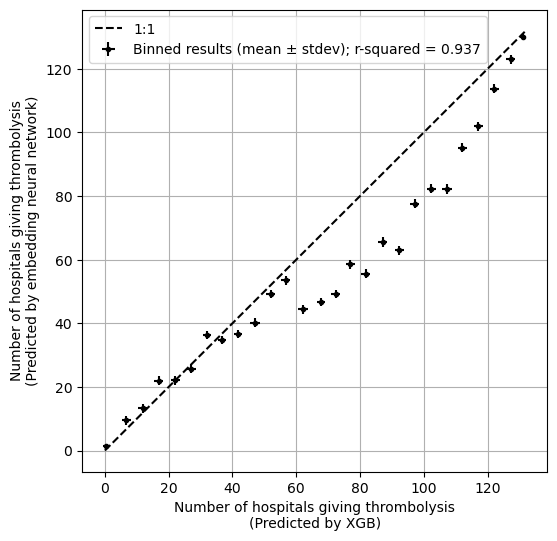

In [5]:
# Bin by XGBoost number of hospitals thrombolsying
bins = np.arange(0, 135, 5)
data['binned_by_xgb_hospitals_thrombolysing'] = np.digitize(data['xgb_#_hosp_thrombolysis'], bins=bins)

# Get mean and standard deviation
group_stats = data.groupby(
    'binned_by_xgb_hospitals_thrombolysing')[['xgb_#_hosp_thrombolysis', 'nn_#_hosp_thrombolysis']].agg(['mean', 'std'])

# Plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = group_stats['xgb_#_hosp_thrombolysis']['mean']
x_err = group_stats['xgb_#_hosp_thrombolysis']['std']
y = group_stats['nn_#_hosp_thrombolysis']['mean']
y_err = group_stats['xgb_#_hosp_thrombolysis']['std']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

ax.errorbar(x, y, xerr=x_err, yerr=y_err, 
            fmt='o', color='k', ecolor='k', capsize=0, markersize=3,
            label=f'Binned results (mean ± stdev); r-squared = {r_square:0.3f}')

ax.plot([0,132],[0,132], c='k', ls='--', label='1:1')

ax.grid()
ax.set_xlabel('Number of hospitals giving thrombolysis\n(Predicted by XGB)')
ax.set_ylabel('Number of hospitals giving thrombolysis\n(Predicted by embedding neural network)')
ax.legend()

plt.savefig('./output/62_xgb_10_features_10k_thrombolysing_hopsitals.jpg', dpi=300)

plt.show()

## Compare XGB hospital main SHAP and neural net hospital embedding

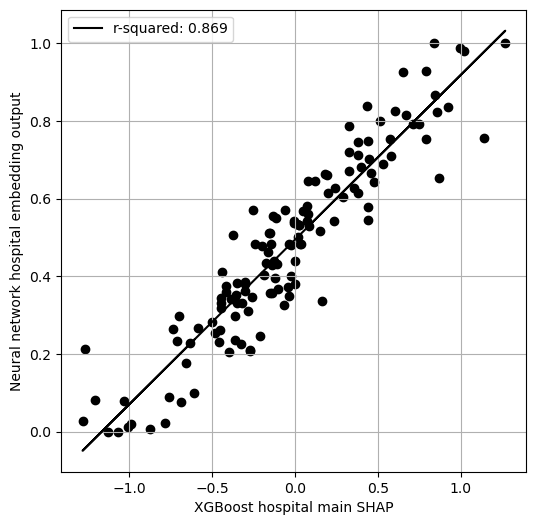

In [6]:
# Scale neural net hospital embedding 0-1. We reverse the embedding to be in same direction as SHAP
def scale_data(data):
    scaled_data = (data - data.min())/ (data.max() - data.min())
    return scaled_data

reversed_nn_hospital_results = data['nn_hospital_subnet_output'] * -1
scaled_nn_hospital_results = scale_data(reversed_nn_hospital_results)
data['scaled_nn_hopsital_embedding'] = scaled_nn_hospital_results

# Get mean results by stroke team
mean_hospital_results = data.groupby('Stroke team').mean()
mean_hospital_results

# Plot results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = mean_hospital_results['xgb_shap_hospital_main_shap']
y = mean_hospital_results['scaled_nn_hopsital_embedding']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

ax.scatter(x, y, c='k')
ax.plot (x, y_pred, color = 'k', linestyle='-', label=f'r-squared: {r_square:0.3f}')

ax.set_xlabel('XGBoost hospital main SHAP')
ax.set_ylabel('Neural network hospital embedding output')

ax.legend()
ax.grid()

plt.savefig('./output/62_xgb_10_features_10k_hospital_embedding.jpg', dpi=300)
plt.show()

In [7]:
mean_hospital_results

,Order,Thrombolysis,xgb_shap_patient_subset_total,xgb_shap_hospital_subset_total,xgb_shap_hospital_main_shap,xgb_total_shap_without_base,xgb_total_shap_with_base,xgb_probs,xgb_thrombolysis,xgb_#_hosp_thrombolysis,nn_probs,nn_thrombolysis,nn_patient_subnet_output,nn_hospital_subnet_output,nn_#_hosp_thrombolysis,binned_by_xgb_hospitals_thrombolysing,scaled_nn_hopsital_embedding
Stroke team,,,,,,,,,,,,,,,,,
AGNOF1041H,4634.242424,0.353535,-1.277545,-0.012273,0.079162,0.246677,-2.698788,0.316010,0.333333,43.787879,0.320879,0.343434,0.553946,0.4400,39.535354,9.555556,0.5600
AKCGO9726K,5202.931250,0.368750,-1.119019,0.674494,0.436456,1.242019,-1.703319,0.370694,0.400000,38.956250,0.361337,0.375000,0.564783,0.1604,29.856250,8.556250,0.8396
AOBTM3098N,4573.353846,0.215385,-0.967369,-1.241631,-0.458154,-0.390677,-3.336031,0.204569,0.184615,30.676923,0.203908,0.138462,0.549163,0.7680,31.246154,6.938462,0.2320
APXEE8191H,4832.153846,0.230769,-2.137754,-0.088015,0.019615,-0.457538,-3.402923,0.265554,0.261538,33.923077,0.245615,0.246154,0.625352,0.4977,30.153846,7.584615,0.5023
ATDID5461S,4720.628571,0.228571,-1.589829,-1.587029,0.162314,-1.297229,-4.242629,0.188457,0.142857,17.628571,0.186143,0.142857,0.577537,0.6642,25.400000,4.342857,0.3358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,4308.916667,0.250000,-0.563917,-1.321306,-0.281667,-0.121611,-3.066889,0.257917,0.250000,35.416667,0.249778,0.194444,0.506861,0.6906,38.527778,7.888889,0.3094
YQMZV4284N,4881.094340,0.245283,-2.847962,-0.236906,0.474566,-1.404604,-4.349962,0.217396,0.226415,24.849057,0.219415,0.207547,0.672417,0.3566,21.943396,5.867925,0.6434
ZBVSO0975W,5384.836735,0.244898,-1.819796,-0.573816,-0.581980,-0.520633,-3.466000,0.252592,0.244898,41.591837,0.226265,0.183673,0.579149,0.7326,36.306122,9.122449,0.2674


### Compare ranks

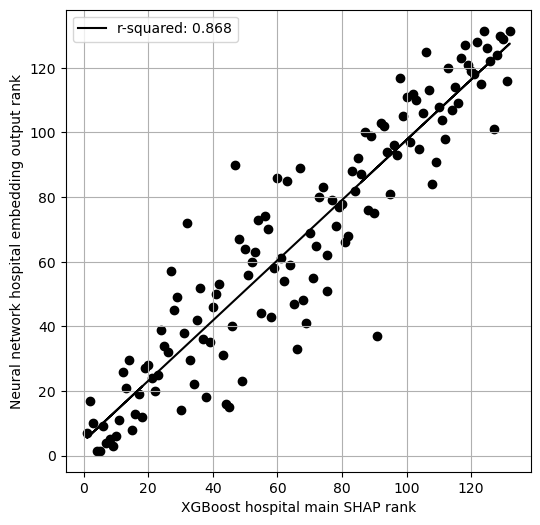

In [8]:
mean_hospital_results['xgb_hospital_rank'] = mean_hospital_results['xgb_shap_hospital_main_shap'].rank()
mean_hospital_results['nn_hospital_rank'] = mean_hospital_results['scaled_nn_hopsital_embedding'].rank()

x = mean_hospital_results['xgb_hospital_rank']
y = mean_hospital_results['nn_hospital_rank']

# Plot results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

ax.scatter(x, y, c='k')
ax.plot (x, y_pred, color = 'k', linestyle='-', label=f'r-squared: {r_square:0.3f}')

ax.set_xlabel('XGBoost hospital main SHAP rank')
ax.set_ylabel('Neural network hospital embedding output rank')

ax.legend()
ax.grid()

plt.savefig('./output/62_xgb_10_features_10k_hospital_rank.jpg', dpi=300)
plt.show()

In [9]:
mean_hospital_results.head()

,Order,Thrombolysis,xgb_shap_patient_subset_total,xgb_shap_hospital_subset_total,xgb_shap_hospital_main_shap,xgb_total_shap_without_base,xgb_total_shap_with_base,xgb_probs,xgb_thrombolysis,xgb_#_hosp_thrombolysis,nn_probs,nn_thrombolysis,nn_patient_subnet_output,nn_hospital_subnet_output,nn_#_hosp_thrombolysis,binned_by_xgb_hospitals_thrombolysing,scaled_nn_hopsital_embedding,xgb_hospital_rank,nn_hospital_rank
Stroke team,,,,,,,,,,,,,,,,,,,
AGNOF1041H,4634.242424,0.353535,-1.277545,-0.012273,0.079162,0.246677,-2.698788,0.316010,0.333333,43.787879,0.320879,0.343434,0.553946,0.4400,39.535354,9.555556,0.5600,86.0,87.0
AKCGO9726K,5202.931250,0.368750,-1.119019,0.674494,0.436456,1.242019,-1.703319,0.370694,0.400000,38.956250,0.361337,0.375000,0.564783,0.1604,29.856250,8.556250,0.8396,106.0,125.0
AOBTM3098N,4573.353846,0.215385,-0.967369,-1.241631,-0.458154,-0.390677,-3.336031,0.204569,0.184615,30.676923,0.203908,0.138462,0.549163,0.7680,31.246154,6.938462,0.2320,22.0,20.0
APXEE8191H,4832.153846,0.230769,-2.137754,-0.088015,0.019615,-0.457538,-3.402923,0.265554,0.261538,33.923077,0.245615,0.246154,0.625352,0.4977,30.153846,7.584615,0.5023,78.0,71.0
ATDID5461S,4720.628571,0.228571,-1.589829,-1.587029,0.162314,-1.297229,-4.242629,0.188457,0.142857,17.628571,0.186143,0.142857,0.577537,0.6642,25.400000,4.342857,0.3358,91.0,37.0


## Compare XGB patient SHAP and neural net patient embedding

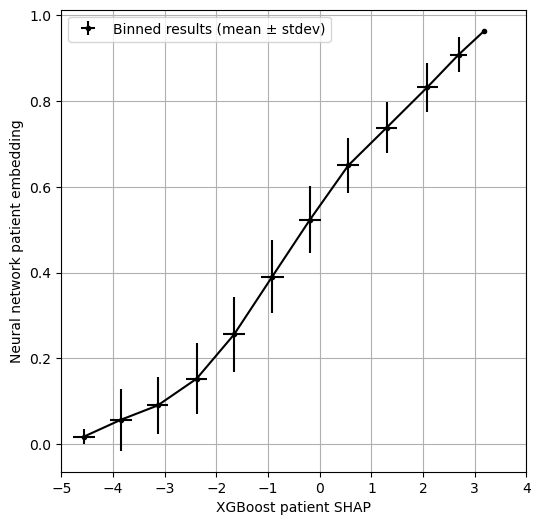

In [10]:
# Scale neural net patient embedding 0-1. We reverse the embedding to be in same direction as SHAP
def scale_data(data):
    scaled_data = (data - data.min())/ (data.max() - data.min())
    return scaled_data

reversed_nn_patient_results = data['nn_patient_subnet_output'] * -1
scaled_nn_patient_results = scale_data(reversed_nn_patient_results)
data['scaled_nn_patient_embedding'] = scaled_nn_patient_results

# Bin data by XGBoost patient SHAP
bins = np.linspace(data['xgb_shap_patient_subset_total'].min(), data['xgb_shap_patient_subset_total'].max(), 21)
data['binned_by_xgb_patient_shap'] = np.digitize(data['xgb_shap_patient_subset_total'], bins=bins)

# Restrict data to SHAP > -5
mask = data['xgb_shap_patient_subset_total'] > -5

# Get mean and standard deviation
group_stats = data[mask].groupby(
    'binned_by_xgb_patient_shap')[['xgb_shap_patient_subset_total', 'scaled_nn_patient_embedding']].agg(['mean', 'std'])

# Plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = group_stats['xgb_shap_patient_subset_total']['mean']
x_err = group_stats['xgb_shap_patient_subset_total']['std']
y = group_stats['scaled_nn_patient_embedding']['mean']
y_err = group_stats['scaled_nn_patient_embedding']['std']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

ax.errorbar(x, y, xerr=x_err, yerr=y_err, 
            fmt='o', color='k', ecolor='k', capsize=0, markersize=3,
            label=f'Binned results (mean ± stdev)')

ax.plot(x, y, linestyle='-', c='k')
ax.set_xlim(-5,4)

ax.grid()
ax.set_xlabel('XGBoost patient SHAP')
ax.set_ylabel('Neural network patient embedding')
ax.legend()

plt.savefig('./output/62_xgb_10_features_10k_patient_embedding.jpg', dpi=300)
plt.show()

## Compare ranks

In [11]:
data['xgb_patient_rank'] = data['xgb_shap_patient_subset_total'].rank()
data['nn_patient_rank'] = data['scaled_nn_patient_embedding'].rank()

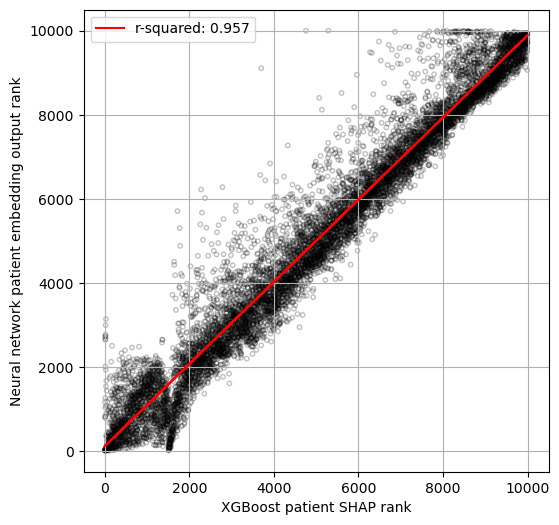

In [12]:
x = data['xgb_patient_rank']
y = data['nn_patient_rank']

# Plot results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

ax.scatter(x, y, edgecolors='k', facecolors='none', alpha=0.25, s=10)
ax.plot (x, y_pred, color = 'r', linestyle='-', label=f'r-squared: {r_square:0.3f}')

ax.set_xlabel('XGBoost patient SHAP rank')
ax.set_ylabel('Neural network patient embedding output rank')

ax.legend()
ax.grid()

plt.savefig('./output/62_xgb_10_features_10k_patient_rank.jpg', dpi=300)
plt.show()